### Define ROI

In [1]:
#SINGLE ROI CASE
roi = 'US_AZ'

### Define some paths

### Init stuff

In [2]:
import pandas as pd
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib
from numpy import *
import pickle
import time

In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

us_abbrev_state = {v: k for k, v in us_state_abbrev.items()}

### Plotting stuff

In [4]:
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

### Other functions

In [5]:
def fix_date(x):
    x = datetime.strftime(datetime.strptime(x, '%m/%d/%y'), '%m/%d/%y')
    return x

def fix_date_covidtrack(x):
    x = datetime.strftime(datetime.strptime(str(x), '%Y%m%d'), '%m/%d/%y')
    return x 

def getDF_covidtrack(roi):
    url = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
    df = pd.read_csv(url)
    DF = pd.DataFrame(columns=['date', 
                               'cum_cases','cum_recover','cum_deaths', 
                               'new_cases', 'new_recover', 'new_deaths'])
    df = df[df['state']==roi]
    date = sort(df['date'].values)
    for i in range(len(date)):
        DF.loc[i] = pd.Series({
                             'date':fix_date_covidtrack(date[i]),
                             'cum_cases':df.loc[df['date']==date[i]]['positive'].values[0],
                             'cum_recover':df.loc[df['date']==date[i]]['recovered'].values[0],
                             'cum_deaths':df.loc[df['date']==date[i]]['death'].values[0],
                            })
    DF[['new_cases', 'new_recover', 'new_deaths']] = \
    DF[['cum_cases',  'cum_recover', 'cum_deaths']].diff()
    if isnan(DF.new_cases.values[0]):
        DF = DF.iloc[1:]
    return DF

def getDF_JHU(roi):
    url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
    url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

    dfc = pd.read_csv(url_confirmed)
    dfr = pd.read_csv(url_recovered)
    dfd = pd.read_csv(url_deaths)


    DF = pd.DataFrame(columns=['date', 
                               'cum_cases','cum_recover','cum_deaths', 
                               'new_cases', 'new_recover', 'new_deaths'])

    date = dfc.columns[4:].values
    try:
        for i in range(len(date)):
          DF.loc[i] = pd.Series({
                                'date':fix_date(date[i]),
                                 'cum_cases':dfc.loc[(dfc['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                 'cum_recover':dfr.loc[(dfr['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                 'cum_deaths':dfd.loc[(dfd['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                })
    except:
        for i in range(len(date)):
          DF.loc[i] = pd.Series({
                                'date':fix_date(date[i]),
                                 'cum_cases':sum(dfc.loc[(dfc['Country/Region']==roi)][date[i]].values),
                                 'cum_recover':sum(dfr.loc[(dfr['Country/Region']==roi)][date[i]].values),
                                 'cum_deaths':sum(dfd.loc[(dfd['Country/Region']==roi)][date[i]].values),
                                })

    DF[['new_cases', 'new_recover', 'new_deaths']] = \
    DF[['cum_cases',  'cum_recover', 'cum_deaths']].diff()

    # print(DF)
    if isnan(DF.new_cases.values[0]):
        DF = DF.iloc[1:]
    return DF



### Load data from url

In [6]:
if roi[:2]=='US':
    DFc = getDF_covidtrack(roi.split('US_')[1])
else:
    DFc = getDF_JHU(roi)

### Load mobility data

In [7]:
DFm = pd.read_csv('Global_Mobility_Report.csv')


if roi[:2]=='US':
    roim = us_abbrev_state[roi.split('US_')[1]]
    DFm = DFm.loc[(DFm.sub_region_1==roim)&pd.isnull(DFm.sub_region_2)]
# else:
#     DFc = getDF_JHU(roi)

/usr/local/Cellar/jupyter/1.0.0_5/libexec/vendor/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Align case and mobility data 

In [8]:
DFm["date"] = pd.to_datetime(DFm["date"])
DFc["date"] = pd.to_datetime(DFc["date"])

DFm = DFm.set_index('date')
DFc = DFc.set_index('date')

DF = DFc.join(DFm)

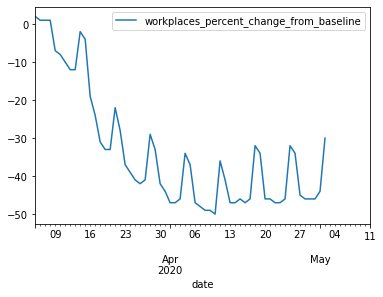

In [17]:
mobkeys = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
DF.plot(y=mobkeys[4],use_index=True)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


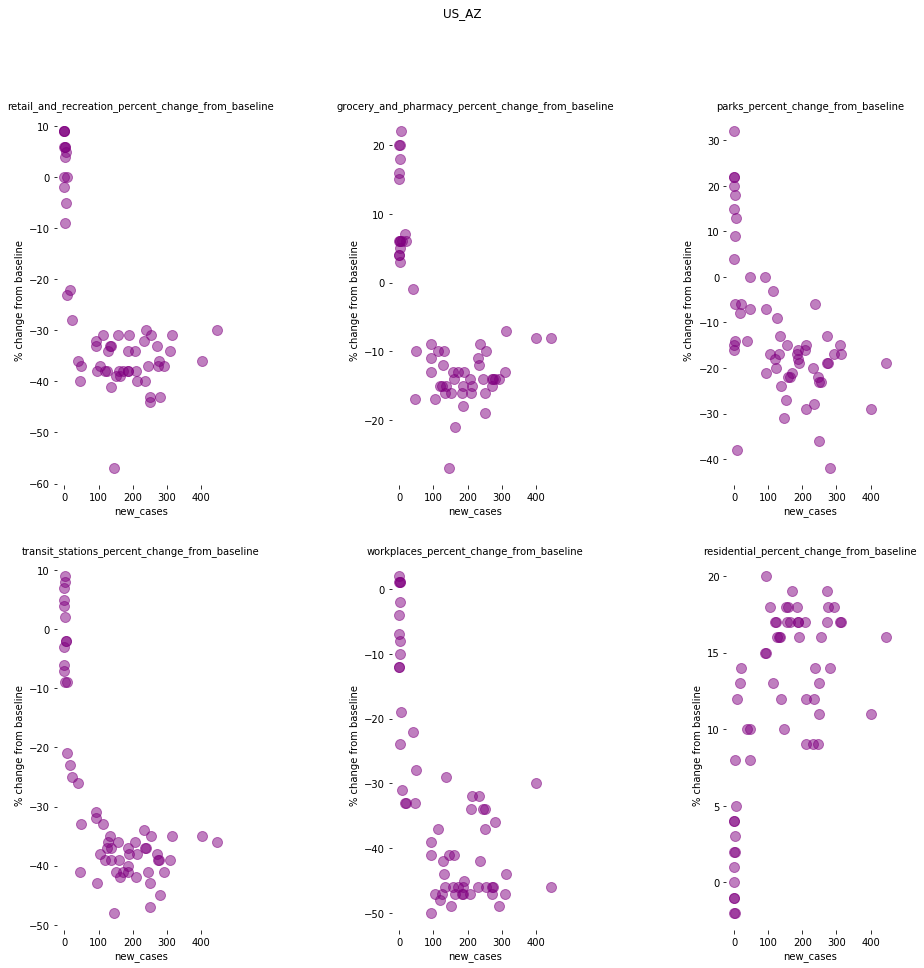

In [9]:

#
f,ax = subplots(2,3,figsize=(15,15))
ax = ax.flatten()
casetype = 'new_cases'
for i in range(len(mobkeys)):
    ax[i].plot(DF[casetype],DF[mobkeys[i]], 'o',color='purple', alpha=0.5, ms=10)
    simpleaxis(ax[i])
    ax[i].set_title(mobkeys[i],fontsize=10)
    ax[i].set_xlabel(casetype,fontsize=10)
    ax[i].set_ylabel('% change from baseline',fontsize=10)
    
suptitle(roi)
subplots_adjust(wspace=1,hspace=0.2)
